In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import svm
from sklearn.feature_selection import RFE

In [2]:
# data from https://www.kaggle.com/hugodarwood/epirecipes/data
raw_data = pd.read_csv('~/Desktop/Data_Science/epicurious/epi_r.csv')

In [3]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

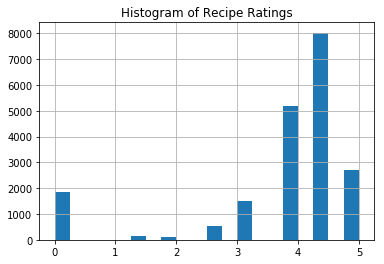

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [7]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

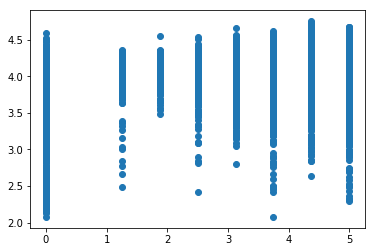

In [8]:
plt.scatter(Y, svr.predict(X))

## Challenge

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

### Take a sample to expedite processing

In [3]:
recipes = raw_data.sample(frac=0.1)

In [4]:
recipes.rating.describe()

count    2005.000000
mean        3.692955
std         1.375492
min         0.000000
25%         3.750000
50%         4.375000
75%         4.375000
max         5.000000
Name: rating, dtype: float64

In [5]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

### Define classifier variable

Let's start by creating a new metric for good ratings, defined as 75th quantile and above.

In [6]:
recipes['rating'].quantile(.75)

4.375

In [33]:
recipes['good_rating'] = 0
recipes.loc[recipes['rating'] >= 4.375, 'good_rating'] = 1
X = recipes.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)
Y = recipes.good_rating

In [34]:
X.shape

(2005, 674)

In [35]:
Y.value_counts()

1    1087
0     918
Name: good_rating, dtype: int64

Our good rating now covers about 54% of the recipes in our data.


### Lasso for feature selection

In [18]:
# test effects of regularization
lasso = LogisticRegression(C=1, penalty="l1")
score = cross_val_score(lasso, X, Y, cv=5)
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))

Cross Validation Score Range: 0.55 to 0.59


In [14]:
lasso = LogisticRegression(C=10, penalty="l1")
score = cross_val_score(lasso, X, Y, cv=5)
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))

Cross Validation Score Range: 0.54 to 0.61


In [15]:
lasso = LogisticRegression(C=100, penalty="l1")
score = cross_val_score(lasso, X, Y, cv=5)
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))

Cross Validation Score Range: 0.54 to 0.60


In [16]:
lasso = LogisticRegression(C=1000, penalty="l1")
score = cross_val_score(lasso, X, Y, cv=5)
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))

Cross Validation Score Range: 0.54 to 0.60


In [19]:
lasso = LogisticRegression(C=10000, penalty="l1")
score = cross_val_score(lasso, X, Y, cv=5)
print("Cross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))

Cross Validation Score Range: 0.54 to 0.60


In [36]:
#fit model with minimal regularization
lass = LogisticRegression(C=10000, penalty="l1")
lassfit = lass.fit(X, Y)

In [37]:
# create dataframe to collect coefficients from lasso model
features = pd.DataFrame({"Features": X.columns, "Coefficients": lassfit.coef_[0]})

# collect features with coefficents of 0
zero_features = features[features["Coefficients"] == 0]

In [38]:
zero_features.shape

(142, 2)

In [39]:
# create list of 139 features to drop
zero_list = zero_features['Features'].tolist()
print(zero_list)

['#cakeweek', '#wasteless', '30 days of groceries', 'alabama', 'alaska', 'anthony bourdain', 'aspen', 'australia', 'biscuit', 'boston', 'bran', 'brownie', 'bulgaria', 'burrito', 'butterscotch/caramel', 'calvados', 'cambridge', 'canada', 'caviar', 'chambord', 'cobbler/crumble', 'columbus', 'cook like a diner', 'cookbook critic', 'costa mesa', 'cranberry sauce', 'crêpe', 'cr��me de cacao', 'cuba', 'custard', 'dallas', 'denver', 'digestif', 'dominican republic', 'dorie greenspan', 'eau de vie', 'egypt', 'emeril lagasse', 'england', 'epi + ushg', 'epi loves the microwave', 'flat bread', 'frankenrecipe', 'freezer food', 'friendsgiving', 'frittata', 'fritter', 'germany', 'grains', 'grand marnier', 'granola', 'grappa', 'guam', 'haiti', 'hawaii', 'hollywood', 'houston', 'ice cream', 'iced coffee', 'idaho', 'indiana', 'iowa', 'italy', 'japan', 'juicer', 'kentucky', 'kitchen olympics', 'labor day', 'lancaster', 'las vegas', 'lasagna', 'london', 'long beach', 'louisiana', 'louisville', 'maine', '

In [41]:
# remove features
X = X.drop(columns=zero_list)

X.shape

(2005, 532)

### Test SVM Classifier Model

In [42]:
svc = svm.SVC()
# define svc function to display accuracy via cross validation
def svc_model(data, target):
    #fit model
    svc.fit(data,target)
    #score accuracy
    score = cross_val_score(svc, data, target, cv=5)
    #return results
    print("SVM Model \n")
    print("Cross Validation Scores:\n", score)
    print("\nCross Validation Score Range: %0.2f to %0.2f" % (score.min(), score.max()))
    print("\nCross Validation mean of: %0.2f (+/- %0.2f)" % (score.mean(), score.std()))
    

In [43]:
#test classifier accuracy with all features
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.54228856 0.54228856 0.54114713 0.5425     0.5425    ]

Cross Validation Score Range: 0.54 to 0.54

Cross Validation mean of: 0.54 (+/- 0.00)


Inital test shows a good fit, but accuracy is no better than the baseline.

Let's try tossing out some features

### Test frequently occurring subset of features

In [45]:
# identify most frequent features

frequency = pd.DataFrame()
column_data = []

def category_test(i):
    data = pd.DataFrame({"item": [i], "counts": [X[i].sum()]})
    return data

for i in X.columns:
    result = category_test(i)
    column_data.append(result)
frequency = pd.concat(column_data, ignore_index=True)

frequent = frequency.loc[frequency['counts'] > frequency['counts'].quantile(.75)]
frequent.head()

,counts,item
3,89.0,alcoholic
4,50.0,almond
10,133.0,appetizer
11,64.0,apple
22,91.0,backyard bbq


In [46]:
# create subset of features with most frequently cited variables

frequent_list = frequent['item'].tolist()
X = X.filter(items=frequent_list)

In [47]:
X.shape

(2005, 133)

In [48]:
# re-fit model and display test results
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.57960199 0.60447761 0.59850374 0.5675     0.54      ]

Cross Validation Score Range: 0.54 to 0.60

Cross Validation mean of: 0.58 (+/- 0.02)


The model is overfitting and accuracy is just barely better than the baseline

### Test smaller subset of features

In [49]:
# select 10 most frequently present features
top_10 = frequent.nlargest(10, 'counts')
print(top_10)

     counts               item
48    963.0        bon appétit
353   829.0        peanut free
455   802.0           soy free
495   717.0      tree nut free
192   651.0            gourmet
506   641.0         vegetarian
243   601.0             kosher
361   576.0        pescatarian
395   552.0       quick & easy
519   501.0  wheat/gluten-free


In [50]:
top_10_list = top_10['item'].tolist()
X = X.filter(items=top_10_list)

In [51]:
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.52487562 0.57960199 0.57356608 0.5625     0.57      ]

Cross Validation Score Range: 0.52 to 0.58

Cross Validation mean of: 0.56 (+/- 0.02)


Using only the top ten most frequent features, our accuracy is worse than before and we're still overfitting.  Let's try a few more features.

### Re-test with slightly larger subset of features

In [52]:
# select 30 most frequently present features
top_30 = frequent.nlargest(30, 'counts')
top_30_list = top_30['item'].tolist()
X = X.filter(items=top_30_list)

In [53]:
#test model with revised features
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.52487562 0.57960199 0.57356608 0.5625     0.57      ]

Cross Validation Score Range: 0.52 to 0.58

Cross Validation mean of: 0.56 (+/- 0.02)


That didn't do any better.  Let's try try less frequently occurring features

### Re-test with infrequently occurring subset of features

In [54]:
# identify features with frequency below mean
infrequent = frequency.loc[frequency['counts'] < frequency['counts'].quantile(.5)]
infrequent_list = infrequent['item'].tolist()
#reset data
X = recipes.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)
# featureelimination reset
X = X.drop(columns=zero_list)
#filter X for infrequent features
X = X.filter(items=infrequent_list)

In [55]:
X.shape

(2005, 265)

In [56]:
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.54228856 0.54228856 0.54114713 0.5425     0.5425    ]

Cross Validation Score Range: 0.54 to 0.54

Cross Validation mean of: 0.54 (+/- 0.00)


The infrequent features are no better than bseline.  Let's try some kernel tests

### Retry model with Linear Kernel

In [57]:
# reset data with feature selection
X = recipes.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good_rating'], 1)
X = X.drop(columns=zero_list)

In [60]:
svc = svm.SVC(kernel='linear')
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.60945274 0.59950249 0.61346633 0.5675     0.55      ]

Cross Validation Score Range: 0.55 to 0.61

Cross Validation mean of: 0.59 (+/- 0.02)


The linear kernal improved accuracy, but with the cost of overfitting.

### Retry model with Poly Kernel

In [61]:
svc = svm.SVC(kernel='poly')
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.54228856 0.54228856 0.54114713 0.5425     0.5425    ]

Cross Validation Score Range: 0.54 to 0.54

Cross Validation mean of: 0.54 (+/- 0.00)


The poly kernal resolved the overfitting, but at the cost of accuracy - we're back to the baseline.

### Retry model with Sigmoid Kernel

In [62]:
svc = svm.SVC(kernel='sigmoid')
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.54228856 0.54228856 0.54114713 0.5425     0.5425    ]

Cross Validation Score Range: 0.54 to 0.54

Cross Validation mean of: 0.54 (+/- 0.00)


The sigmoid kernal has the same result as the poly kernel

Let's try some model tuning.

### Tune model's penalty parameter

In [66]:
svc = svm.SVC(C=10)
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.59950249 0.6318408  0.60099751 0.59       0.56      ]

Cross Validation Score Range: 0.56 to 0.63

Cross Validation mean of: 0.60 (+/- 0.02)


In [68]:
svc = svm.SVC(C=5)
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.59701493 0.61940299 0.6159601  0.6025     0.5475    ]

Cross Validation Score Range: 0.55 to 0.62

Cross Validation mean of: 0.60 (+/- 0.03)


In [70]:
svc = svm.SVC(C=1)
svc_model(X,Y)

SVM Model 

Cross Validation Scores:
 [0.54228856 0.54228856 0.54114713 0.5425     0.5425    ]

Cross Validation Score Range: 0.54 to 0.54

Cross Validation mean of: 0.54 (+/- 0.00)


In [71]:
# tune penalty parameter of svm

svm_results = pd.DataFrame()

def lambda_test(value):
    #Test values
    svc = svm.SVC(C=value) 
    score = cross_val_score(svc, X, Y, cv=5)
    #return dataframe of r-squared for each lambda value
    data = pd.DataFrame({"lambda_value": [value], "score": [score.mean()], "std": [score.std()]})
    return data

appended_data = []
lambda_range = np.arange(1, 4, 0.1)
for i in lambda_range:
    result = lambda_test(i)
    appended_data.append(result)
svm_results = pd.concat(appended_data, ignore_index=True)



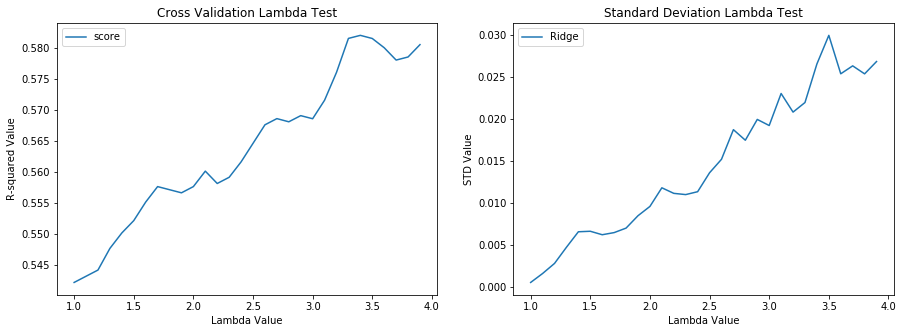

In [72]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(svm_results['lambda_value'], svm_results['score'])
plt.xlabel('Lambda Value')
plt.ylabel('R-squared Value')
plt.legend(loc='best') 
plt.title('Cross Validation Lambda Test')

plt.subplot(1, 2, 2)
plt.plot(svm_results['lambda_value'], svm_results['std'], label="Ridge")
plt.xlabel('Lambda Value')
plt.ylabel('STD Value')
plt.legend(loc='best') 
plt.title('Standard Deviation Lambda Test')

plt.show()

In this case, tuning the penalty parameter of our model does not help with overfitting or predictive power.